# step 58. VGG16
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/58_1.png?raw=true">

In [ ]:
import dezero.functions as F
import dezero.layers as L
from dezero import utils

class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/releases/download/v0.1/vgg16.npz'
    def __init__(self, pretrained = False):
        super().__init__()
        # 입력 채널 수를 미리 지정하지 않음 (순전파 시에 흐르는 데이터로부터 얻고 그 시점에 가중치 초기화)
        self.conv1_1 = L.Conv2d(64, kernel_size = 3, stride = 1, pad = 1)
        self.conv1_2 = L.Conv2d(64, kernel_size = 3, stride = 1, pad = 1)
        self.conv2_1 = L.Conv2d(128, kernel_size = 3, stride = 1, pad = 1)
        self.conv2_2 = L.Conv2d(128, kernel_size = 3, stride = 1, pad = 1)
        self.conv3_1 = L.Conv2d(256, kernel_size = 3, stride = 1, pad = 1)
        self.conv3_2 = L.Conv2d(256, kernel_size = 3, stride = 1, pad = 1)
        self.conv3_4 = L.Conv2d(256, kernel_size = 3, stride = 1, pad = 1)
        self.conv4_1 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        self.conv4_2 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        self.conv4_3 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        self.conv5_1 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        self.conv5_2 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        self.conv5_3 = L.Conv2d(512, kernel_size = 3, stride = 1, pad = 1)
        # 위와 마찬가지로 출력 크기만 지정 (입력 크기는 실제로 흘러들어온 데이터를 보고 자동 결정)
        self.fc6 = L.Linear(4096)
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)
        
        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path) # 부모인 Model 클래스로부터 상속받은 메서드
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))  # flatten
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x
    
    @staticmethod
    def preprocess(image, size=(224, 224), dtype=np.float32):
        image = image.convert('RGB')                                
        if size:
            image = image.resize(size)                              # resizing
        image = np.asarray(image, dtype=dtype)                      # image2np
        image = image[:, :, ::-1]                                   # RGB를 BGR순서로   
        image -= np.array([103.939, 116.779, 123.68], dtype=dtype)  # 각 채널별 (사전훈련)평균빼기
        image = image.transpose((2, 0, 1))
        return image

Downloading: vgg16.npz
 Done


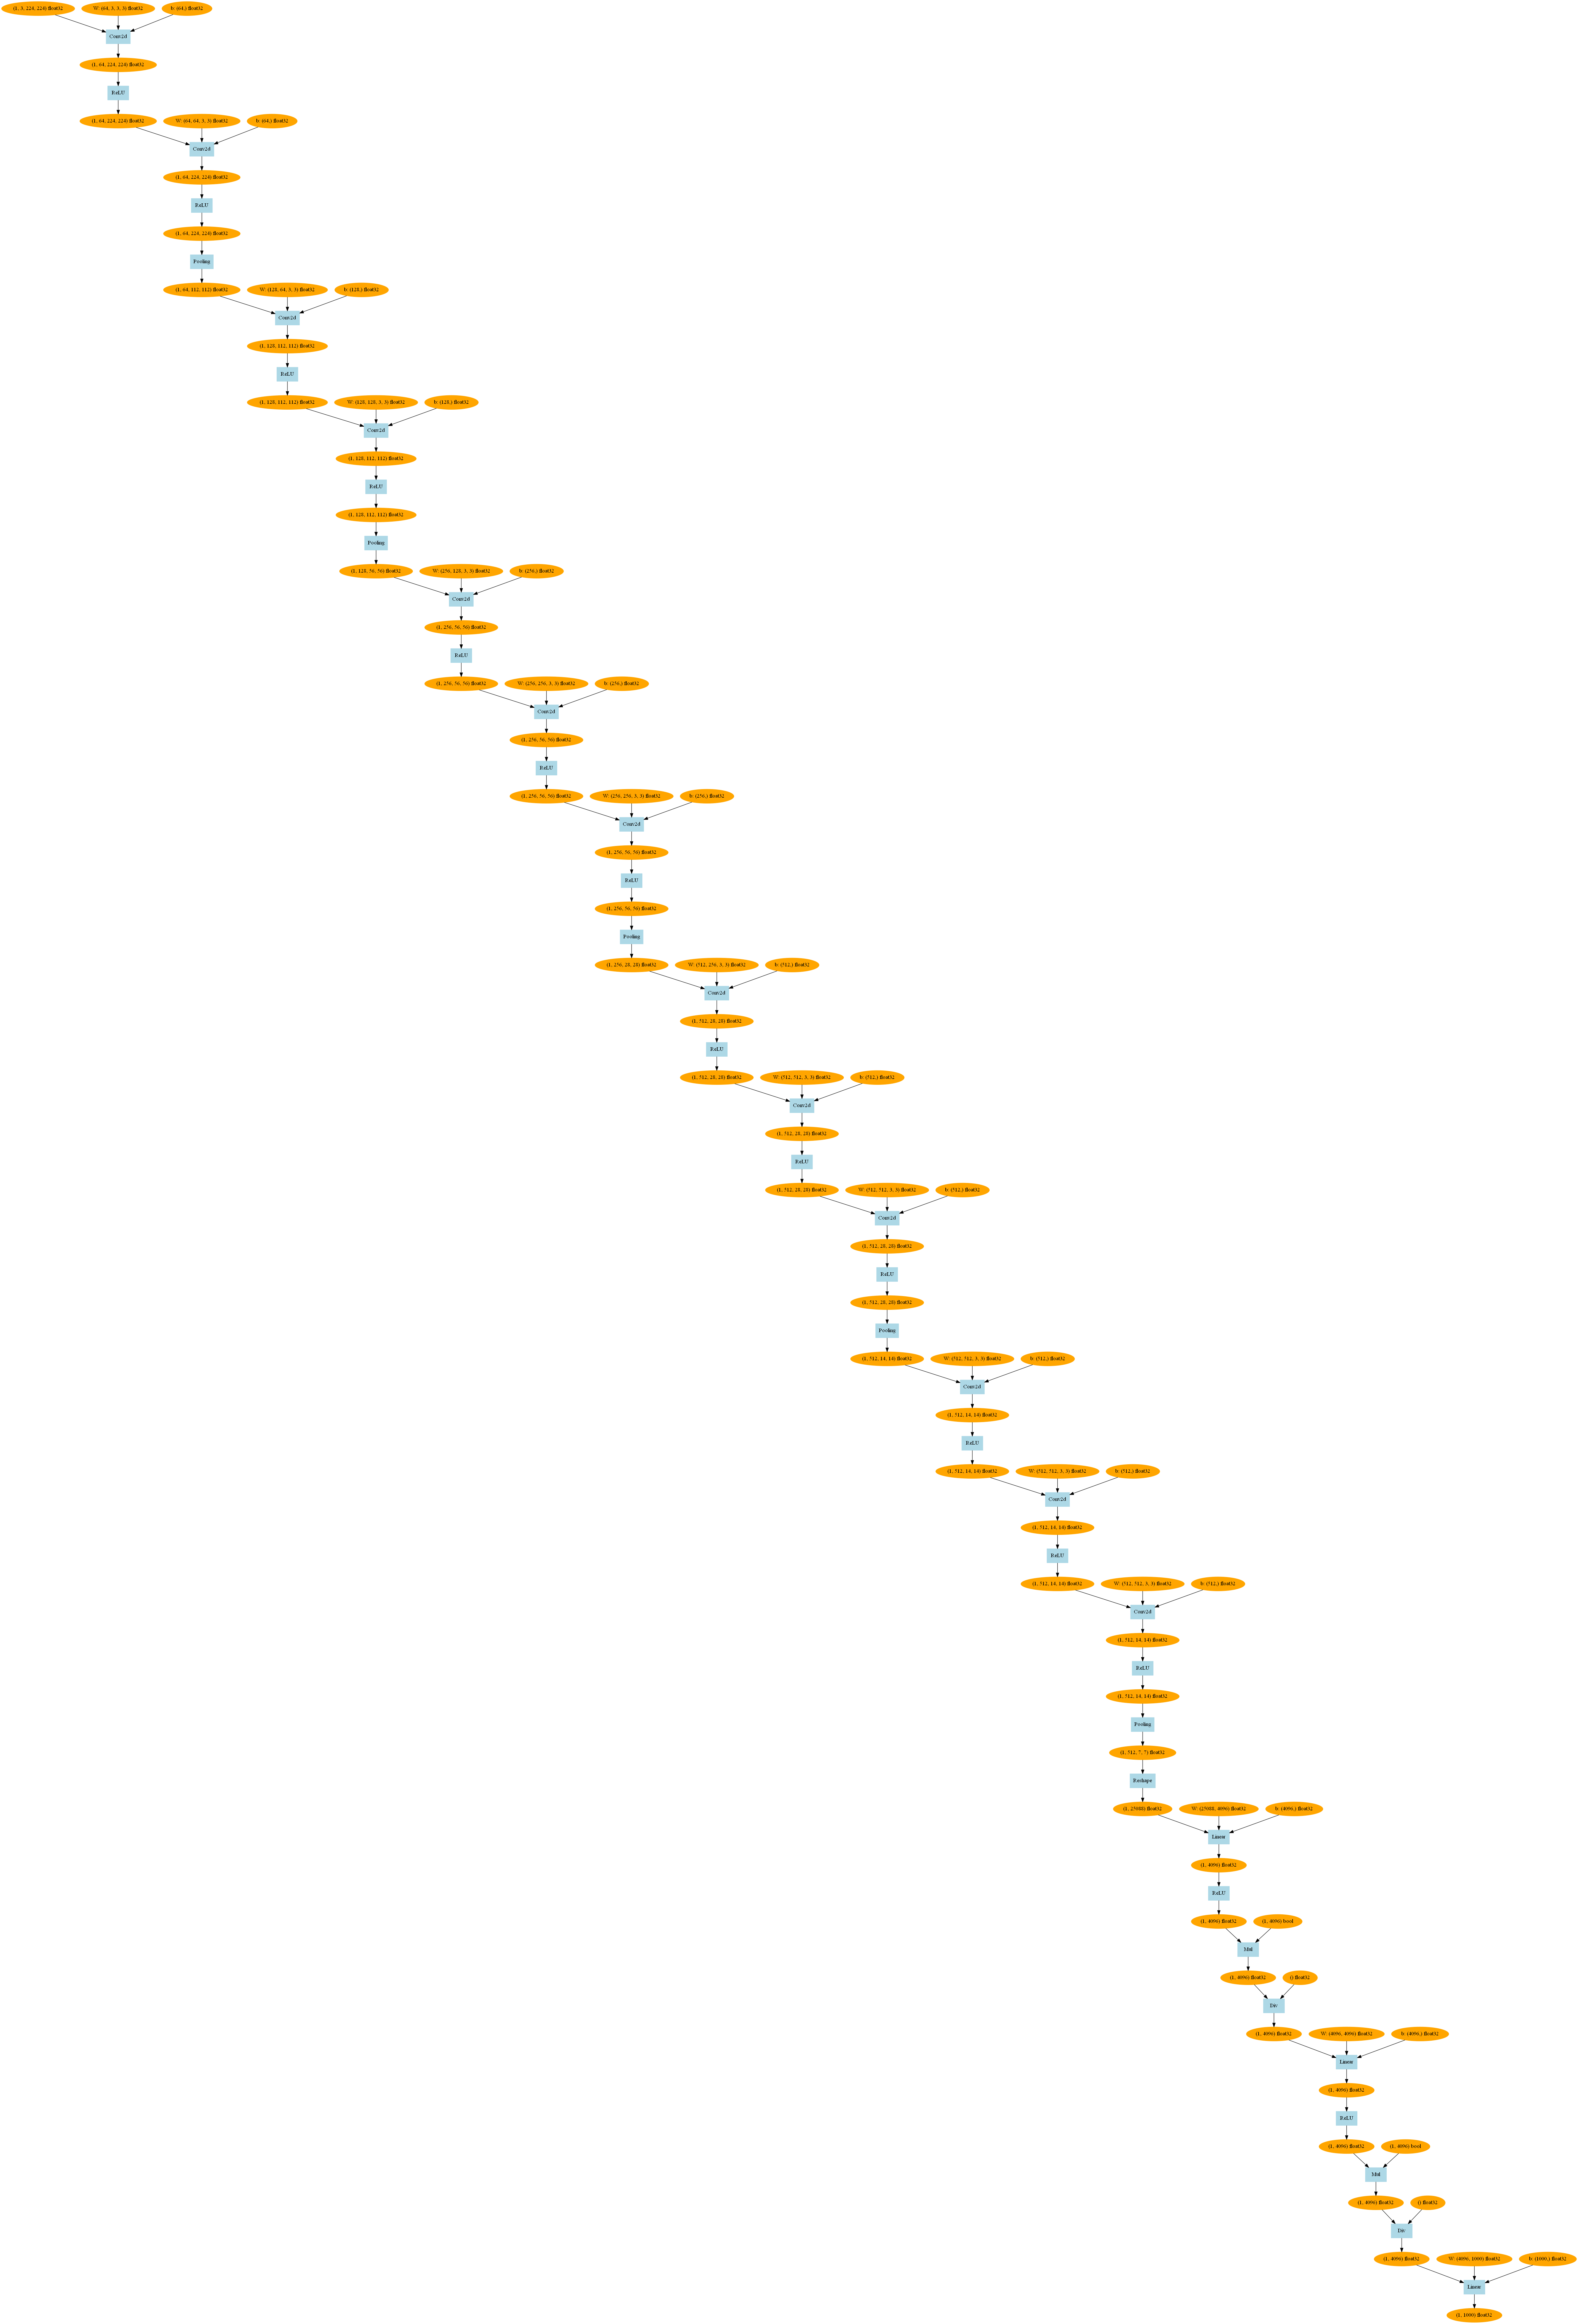

In [1]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained = True)

x = np.random.randn(1, 3, 224, 224).astype(np.float32)
model.plot(x)

In [2]:
import dezero 
from PIL import Image

url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'

img_path = dezero.utils.get_file(url)
img = Image.open(img_path)

# 사전학습 가중치를 사용하여 미지의 데이터에 대해 inference 진행 시
# 새로운 input 데이터에 대해 모델을 학습시켰을 때와 똑같은 전처리를 해줘야 한다. 
x = VGG16.preprocess(img)
x = x[np.newaxis] # 배치 차원 추가 (3, 224, 224) -> (1, 3, 224, 224)

model = VGG16(pretrained=True)
with dezero.test_mode(): # 추론모드
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = dezero.datasets.ImageNet.labels()
print(labels[predict_id])

Downloading: imagenet1000_clsidx_to_labels.txt
 Done
zebra


# step 59. RNN

In [ ]:
class RNN(Layer):
    def __init__(self, hidden_size, in_size = None):
        super().__init__()
        self.x2h = Linear(hidden_size, in_size = in_size)
        self.h2h = Linear(hidden_size, in_size = in_size, nobias = True)
        self.h = None
    
    def reset_state(self):
        self.h = None
    
    # Variable h를 매개로 이전 시각의 계산 그래프와 연결된다.
    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
            
    self.h = h_new
    return h_new

In [1]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


In [7]:
y = rnn(np.random.rand(1,1))
print(h, '\n', y)

variable([[ 0.50690535  0.23266781 -0.33295437  0.27071372  0.04977009  0.35845722
            0.14308367  0.29571519 -0.38553081  0.156796  ]]) 
 variable([[ 0.38295246  0.28652502  0.14506314  0.3082849  -0.07609535  0.1279303
            0.59306467  0.43863978 -0.19924846  0.47405312]])


In [8]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
        
    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

In [ ]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]                 
ts = seq_data[1:]

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    
    cnt += 1
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

두 번째 입력데이터가 들어왔을 때 역전파를 수행한다.<br/>
이 때의 계산 그래프는 아래 그림과 같다.
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/59_4.png?raw=true">
입력 데이터는 원하는 만큼(can be any length) 제공할 수 있지만,<br/> 
역전파가 안정적으로 이루어지기 위해서는 계산 그래프를 적절한 길이에서 끊어줘야 한다.(Truncated BPTT)<BR/>
이때, 계산의 연결은 끊지만 전시점의 은닉상태는 보존되어 이후시점으로 전달되어야한다. 즉,
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/59_5.png?raw=true">
이를 Variable 클래스에 메서드로 구현한다.

999
(array([-0.02420363]), array([0.01040521]))
(array([0.01040521]), array([0.01040517]))
(array([0.01040517]), array([-0.02070731]))


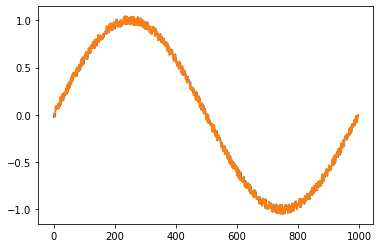

In [12]:
import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train = True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# plotting
raw = [example[0] for example in train_set]
xs = raw[:-1]
ts = raw[1:]
plt.plot(np.arange(len(xs)), xs, label = 'xs')
plt.plot(np.arange(len(ts)), ts, label = 'ts')
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
        
    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y
    
model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# training
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0
    
    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        
        # Truncated BPTT
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()          # initialize gradients : None
            loss.backward()             # calculate new gradients
            loss.unchain_backward()     # creator of all params -> None 
            optimizer.update()          # params update by gradients
            
    avg_loss = float(loss.data) / count # avg loss per epoch
    print(f'| epoch {epoch + 1} | loss {avg_loss}')

| epoch 1 | loss 0.09601603326757434
| epoch 2 | loss 0.03678768778635753
| epoch 3 | loss 0.007328707470329424
| epoch 4 | loss 0.007575774096927274
| epoch 5 | loss 0.0029749790142838445
| epoch 6 | loss 0.002822561431210914
| epoch 7 | loss 0.0026965639180659747
| epoch 8 | loss 0.00395635773914746
| epoch 9 | loss 0.006266842552011539
| epoch 10 | loss 0.008463001251986004
| epoch 11 | loss 0.007555690073595511
| epoch 12 | loss 0.005443219122796363
| epoch 13 | loss 0.004917367277496555
| epoch 14 | loss 0.005457154664193706
| epoch 15 | loss 0.006322627772619216
| epoch 16 | loss 0.006849036693734063
| epoch 17 | loss 0.006737967725990317
| epoch 18 | loss 0.006361524290935685
| epoch 19 | loss 0.006275021075917933
| epoch 20 | loss 0.006523099008330696
| epoch 21 | loss 0.00711536709094632
| epoch 22 | loss 0.007863830526951398
| epoch 23 | loss 0.029971955768270053
| epoch 24 | loss 0.10920382452326916
| epoch 25 | loss 0.1539335614240257
| epoch 26 | loss 0.03659626630678198
|

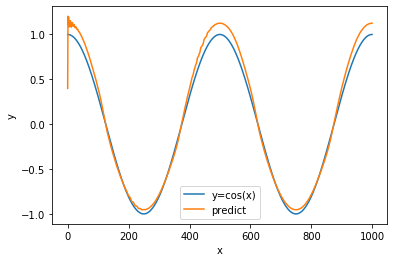

In [14]:
# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# step 60. LSTM & data loader

### data loader for T.S. data

In [ ]:
class SeqDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, gpu = False):
        super().__init__(dataset, batch_size, shuffle = False, gpu = gpu)
        
    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
            
        jump = self.data_size // self.batch_size
        batch_index = [(i * jump + self.iteration) % self.data_size for i in range(self.batch_size)]
        batch = [self.dataset[i] for i in batch_index]
        
        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])
        
        self.iteration += 1

In [ ]:
train_set = dezero.datasets.SinCurve(train = True)
dataloader = SeqDataLoader(train_set, batch_size = 3)
x, t = next(dataloader)
print(x)
print('---------')
print(t)

### LSTM

In [ ]:
class LSTM(Layer):
    def __init__(self, hidden_size, in_size = None):
        super().__init__()
        
        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size = I)
        self.x2i = Linear(H, in_size = I)
        self.x2o = Linear(H, in_size = I)
        self.x2u = Linear(H, in_size = I)
        self.h2f = Linear(H, in_size = H, nobias = True)
        self.h2i = Linear(H, in_size = H, nobias = True)
        self.h2o = Linear(H, in_size = H, nobias = True)
        self.h2u = Linear(H, in_size = H, nobias = True)
        self.reset_state()
        
    def reset_state(self):
        self.h = None
        self.c = None
        
    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))
            
        is self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)
            h_new = o * F.tanh(c_new)
            
            self.h, self.c = h_new, c_new
            return h_new

In [2]:
import numpy as np
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train = True)
dataloader = SeqDataLoader(train_set, batch_size = batch_size)
seqlen = len(train_set)

class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size, out_size)
        self.fc = L.Linear(out_size)
        
    def reset_state(self):
        self.rnn.reset_state()
        
    def forward(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y
    
model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0
    
    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f'%(epoch + 1, avg_loss))

| epoch 1 | loss 0.600754
| epoch 2 | loss 0.476674
| epoch 3 | loss 0.369198
| epoch 4 | loss 0.278404
| epoch 5 | loss 0.204203
| epoch 6 | loss 0.146290
| epoch 7 | loss 0.104032
| epoch 8 | loss 0.076319
| epoch 9 | loss 0.061397
| epoch 10 | loss 0.056758
| epoch 11 | loss 0.059225
| epoch 12 | loss 0.065335
| epoch 13 | loss 0.071925
| epoch 14 | loss 0.076669
| epoch 15 | loss 0.078323
| epoch 16 | loss 0.076636
| epoch 17 | loss 0.072060
| epoch 18 | loss 0.065431
| epoch 19 | loss 0.057696
| epoch 20 | loss 0.049742
| epoch 21 | loss 0.042285
| epoch 22 | loss 0.035828
| epoch 23 | loss 0.030659
| epoch 24 | loss 0.026871
| epoch 25 | loss 0.024403
| epoch 26 | loss 0.023076
| epoch 27 | loss 0.022638
| epoch 28 | loss 0.022802
| epoch 29 | loss 0.023280
| epoch 30 | loss 0.023816
| epoch 31 | loss 0.024201
| epoch 32 | loss 0.024297
| epoch 33 | loss 0.024033
| epoch 34 | loss 0.023407
| epoch 35 | loss 0.022472
| epoch 36 | loss 0.021316
| epoch 37 | loss 0.020053
| epoch 38